# MDETR Model Interpretability with Attribution Guided Factorizatin

## Install Required Libraries (If Needed)

In [12]:
!pip install timm transformers

In [14]:
import gc # for garbage collection used when CUDA is out of memory
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from hubconf import mdetr_efficientnetB5
from collections import defaultdict
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches, lines
from matplotlib.patches import Polygon

import warnings
warnings.filterwarnings("ignore")

## Preliminaries

### Image Normalization

When read an image into memory, the pixels usually have 8-bit integers between $0$ and $255$ for all three channels. But regression models (including neural networks) prefer floating point values within a smaller range. A typical setup is a mean of $0$ and a standard deviation of $1$ like the standard normal distribution. This transformation for images is called *image normalization*.

For the details about the image normalizations in PyTorch please refer to: <https://sparrow.dev/pytorch-normalize/>.

In [15]:
# Standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Colors for Visualizations

In [16]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

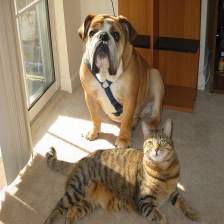

In [17]:
# Read an image from URL.
img_url = "https://github.com/shirgur/AGFVisualization/blob/master/samples/dog-cat.JPEG?raw=true"

# Fetch the image from raw response content.
# Refer to: https://docs.python-requests.org/en/latest/user/quickstart/#raw-response-content
img = Image.open(requests.get(img_url, stream=True).raw)

img


## Import the MDETR Model

In [34]:
model, postprocessor = mdetr_efficientnetB5(pretrained=True, return_postprocessor=True)

In [35]:
# model = model.cuda()
model.eval()

MDETR(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_

In [36]:
# Test for AGF modification.
model.AGF()

AGF Modification Applied:)


### Helper Functions

In [37]:
def bounding_box_coordmapping(bounding_box):
    x_center, y_center, width, height = bounding_box.unbind(1)
    
    box_coordinates = [
        (x_center - 0.5 * width), (y_center - 0.5 * height),
        (x_center + 0.5 * width), (y_center + 0.5 * height)
    ]
    
    return torch.stack(box_coordinates, dim=1)

def rescale_bounding_boxes(output_bounding_box, size):
    width, height = size # unpack size dimensions
    
    # Apply coordinate mapping for bounding boxes.
    scaled_box = bounding_box_coordmapping(output_bounding_box)
    scaled_box *= torch.Tensor([width, height, width, height])
    
    return scaled_box

def apply_mask(img, mask, color, alpha=0.5):
    for color_channel in range(3):
        img[:, :, color_channel] = np.where(
            mask == 1,
            img[:, :, color_channel] * (1 - alpha) + alpha * color_channel[color] * 255,
            img[:, :, color_channel]
        )
    
    return img

def plot_results(img, scores, bounding_boxes, labels, masks=None):
    plt.figure(figsize=(10, 10))
    img_np = np.array(img) # convert the PIL image to a numpy array
    ax = plt.gca() # get current axes instance
    colors = COLORS * 100
    
    if masks is None:
        masks = [None for _ in range(len(scores))]
    
    assert len(scores) == len(bounding_boxes) == len(labels) == len(masks)
    
    for score, (x_min, y_min, x_max, y_max), label, mask, color in zip(
        scores, bounding_boxes.tolist(), labels, masks, colors
    ):
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                   fill=False, color=color, linewidth=2))
        text = f'{label}:{score: 0.4f}'
        ax.text(x_min, y_min, text, fontsize=14, bbox=dict(facecolor='white', alpha=0.8))
        
        if mask is None:
            continue
        
        img_np = apply_mask(img_np, mask, color)
        
        mask_padded = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        mask_padded[1:-1, 1:-1] = mask
        contours = find_contours(mask_padded, 0.5)
        
        for vertex in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            vertex = np.fliplr(vertex) - 1
            polygon = Polygon(vertex, facecolor="none", edgecolor=color)
            ax.add_patch(polygon)
    
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()
    

In [40]:
def plot_inference(img, caption, confidence):
    # Apply mean-std normalization to the input image.
    img_normalized = transform(img).unsqueeze(0)
    
    # Propagate through the model (forwad path)
    memory_cache = model(img_normalized,
                         [caption],
                         encode_and_save=True)

    outputs = model(img_normalized,
                    [caption],
                    encode_and_save=False,
                    memory_cache=memory_cache)
    
    # Keep only predictions with the given confidence level.
    probabilities = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
    keep = (probabilities > confidence).cpu()
    
    # Convert the bounding boxes from [0; 1] to image scales.
    bounding_boxes_scaled = rescale_bounding_boxes(
        outputs['pred_boxes'].cpu()[0, keep], img.size)
    
    # Extract text spans predicted by each box.
    positive_tokens = (
        outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
    predicted_spans = defaultdict(str)
    
    for token in positive_tokens:
        item, position = token
        
        if position < 255:
            span = memory_cache["tokenized"].token_to_chars(0, position)
            predicted_spans[item] += " " + caption[span.start: span.end]
    labels = [predicted_spans[k] for k in sorted(list(predicted_spans.keys()))]
    
    print(f'Extracted labels from query: {labels}')
    
    plot_results(img, probabilities[keep], bounding_boxes_scaled, labels)


## Detection

In [27]:
# ONLY run this when GPU is out of memory

# del model
# gc.collect()
# torch.cuda.empty_cache()

Extracted labels from query: [' cat', ' dog']


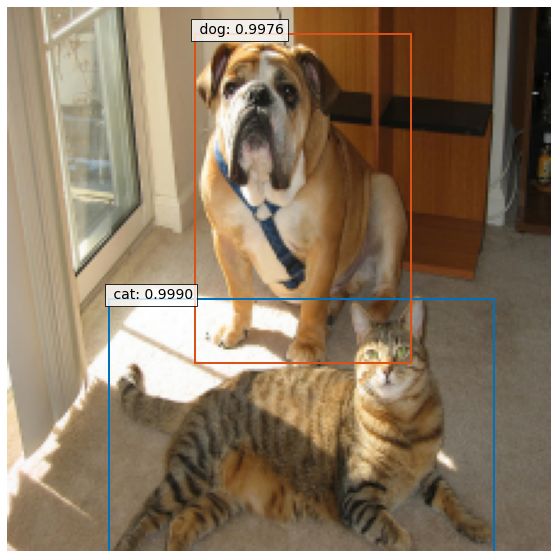

In [41]:
plot_inference(img, "cat and dog", 0.7)